In [57]:
import numpy as np
from matplotlib import pyplot as plt
import pyvista as pv


In [58]:
# ファイル名を指定してデータを読み込む
mesh = pv.read('../data/Tetra_Cells30000/Tetra_Cells30000_4_0.vtu')


/Users/gyakusu/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/gyakusu/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


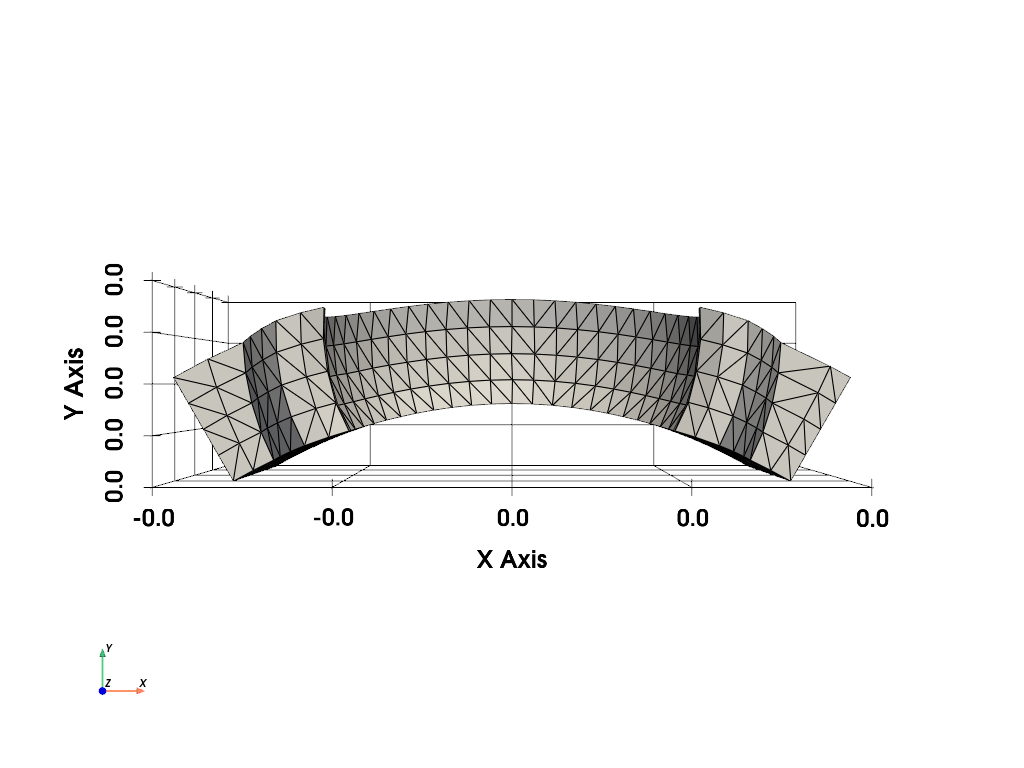

In [3]:
# メッシュデータを表示する
mesh.plot(show_edges=True, show_grid=True, color='w', cpos='xy')


In [4]:
mesh.cells_dict

{5: array([[  0,   1,   2],
        [  3,   4,   5],
        [  6,   3,   5],
        ...,
        [705, 725, 726],
        [726, 694, 685],
        [726, 685, 705]])}

In [5]:
points = np.array(mesh.points.tolist()) 
points.shape


(727, 3)

In [6]:
z_distance = np.linalg.norm(points[:,0:2], axis=1)
z_distance.shape


(727,)

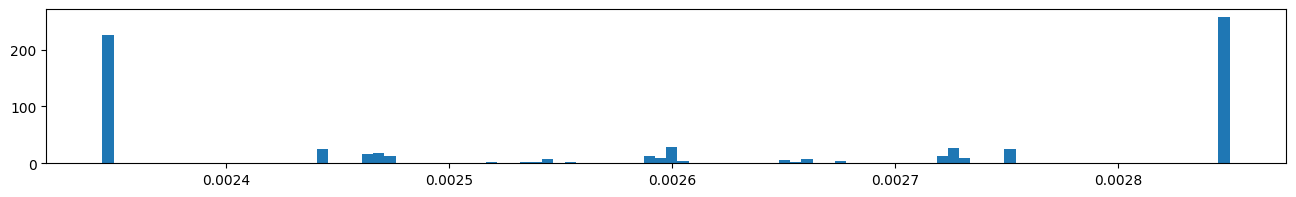

In [7]:
plt.figure(figsize=(16,2))
plt.hist(z_distance, bins=100)
plt.show()


In [8]:
mask = z_distance<0.00245
wall = points[mask]
wall.shape


(250, 3)

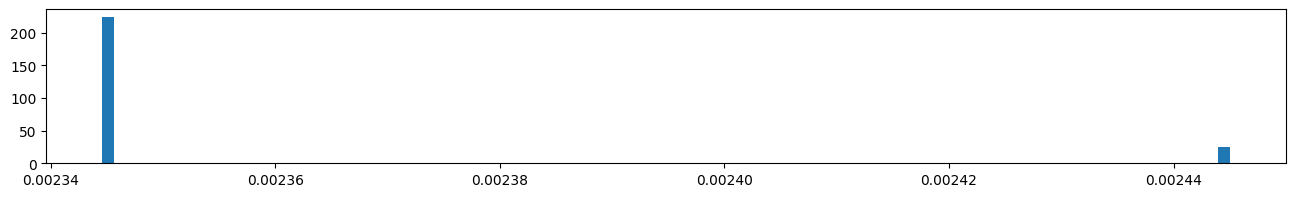

In [9]:
plt.figure(figsize=(16,2))
plt.hist(z_distance[mask], bins=100)
plt.show()


In [10]:
l = np.arctan2(wall[:,0], wall[:,1]) * 0.002345
l.max(), l.min()


(0.0012278392002470584, -0.0012278392364995481)

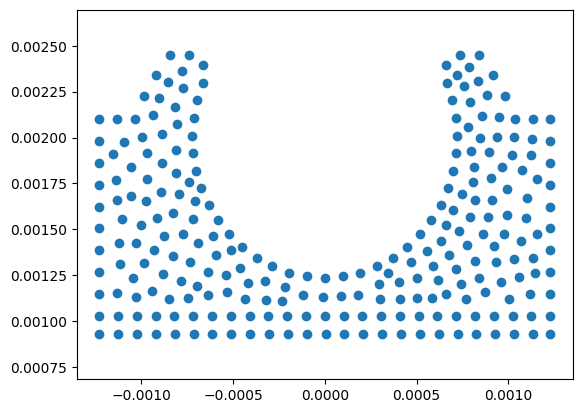

In [11]:
plt.plot(l, wall[:,2], 'o')
plt.axis('equal')
plt.show()



In [12]:
lz = np.array([l, wall[:,2]]).T
lz.shape


(250, 2)

In [13]:
Olz_temp = np.array([0, 0.0020])
Olz_temp_dist = np.linalg.norm(lz - Olz_temp, axis=1)
Olz_temp_dist.shape


(250,)

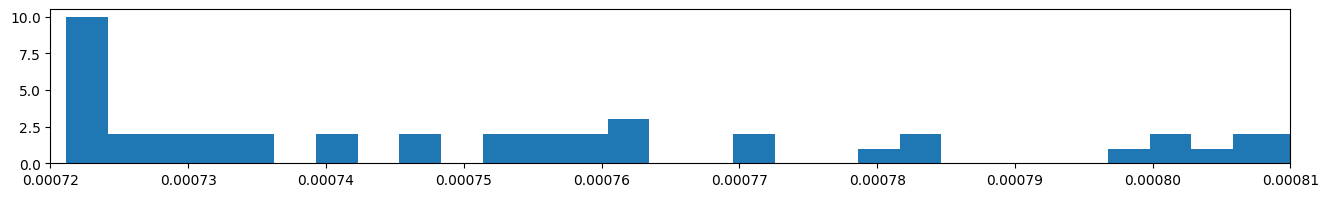

In [14]:
plt.figure(figsize=(16,2))
plt.hist(Olz_temp_dist, bins=300)
plt.xlim([0.00072, 0.00081])
plt.show()


In [15]:
lz_edge = lz[Olz_temp_dist<0.000765]
lz_edge.shape


(31, 2)

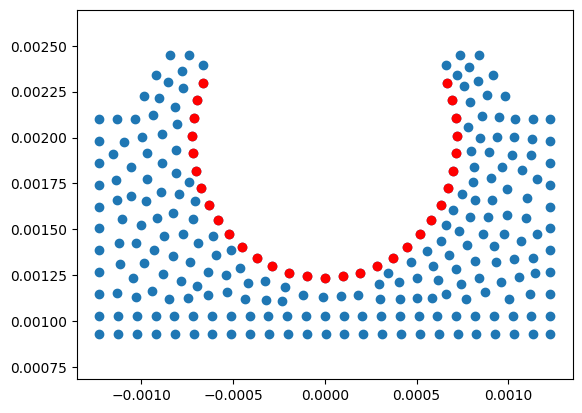

In [16]:
plt.plot(l, wall[:,2], 'o')
plt.plot(lz_edge[:,0], lz_edge[:,1], 'ro')
plt.axis('equal')
plt.show()



In [17]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective(x):
    # Calculate the distances between Olz_temp and lz_edge
    distances = np.linalg.norm([0,x[0]] - lz_edge, axis=1)
    # Calculate the variance of the distances
    variance = np.var(distances)
    return variance

# Define the initial guess for Olz_temp
x0 = Olz_temp[1]

# Perform the optimization
result = minimize(objective, x0)

# Get the optimized point
Olz = np.array([0, result.x[0]])
Olz


array([0.        , 0.00198778])

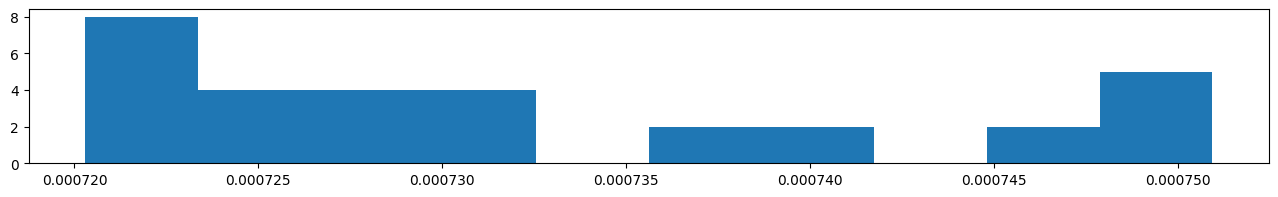

In [18]:
Olz_dist = np.linalg.norm(lz_edge - Olz, axis=1)

plt.figure(figsize=(16,2))
plt.hist(Olz_dist, bins=10)
plt.show()

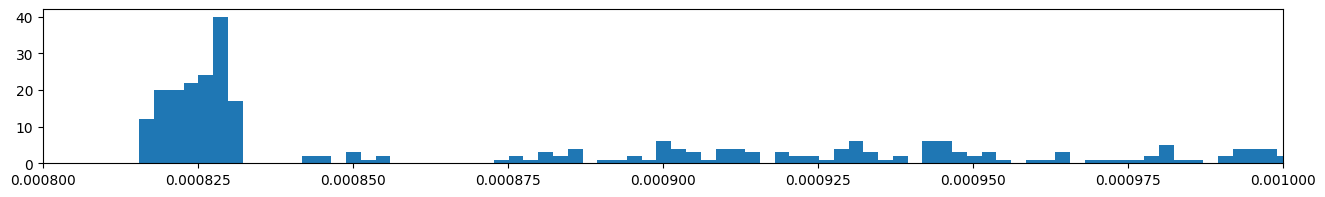

In [19]:
Oxyz_temp = np.array([0, 0.00265, 0.00201])
Oxyz_temp_dist = np.linalg.norm(points - Oxyz_temp, axis=1)

plt.figure(figsize=(16,2))
plt.hist(Oxyz_temp_dist, bins=400)
plt.xlim([0.00080, 0.00100])
plt.show()


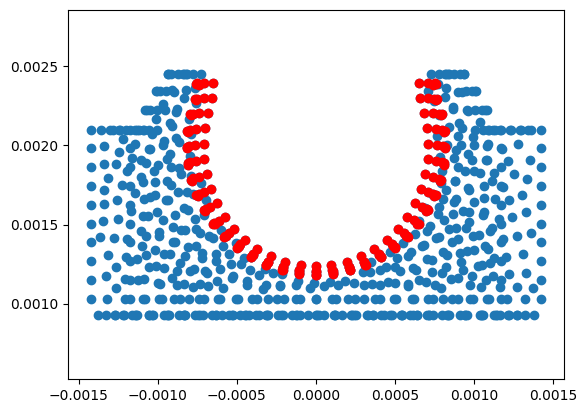

In [20]:
Oxyz_face = points[Oxyz_temp_dist<0.00086]

plt.plot(points[:,0], points[:,2], 'o')
plt.plot(Oxyz_face[:,0], Oxyz_face[:,2], 'ro')
plt.axis('equal')
plt.show()


In [21]:
def objective2(x):
    # Calculate the distances between Oxyz_temp and Oxyz_face
    distances = np.linalg.norm([0,x[0],x[1]] - Oxyz_face, axis=1)
    # Calculate the variance of the distances
    variance = np.var(distances) * 1e6
    return variance

# Define the initial guess for Oxyz_temp
x0 = Oxyz_temp[1:]

# Perform the optimization
result = minimize(objective2, x0)

# Get the optimized point
Oxyz = np.array([0, result.x[0], result.x[1]])
Oxyz


array([0.        , 0.00264713, 0.00200747])

In [22]:
z_distance_face = np.linalg.norm(Oxyz_face[:,0:2], axis=1)
z_distance_face.shape

(165,)

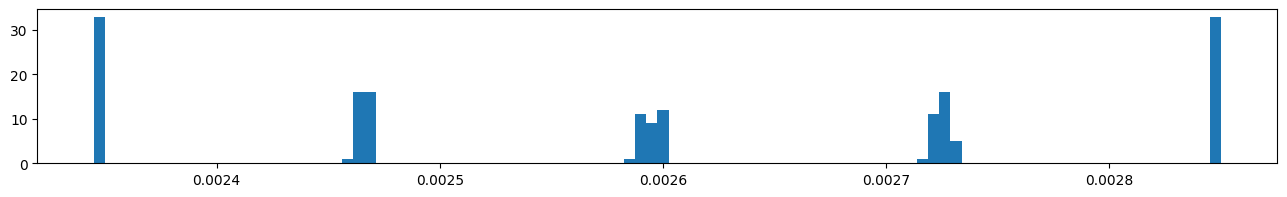

In [23]:
plt.figure(figsize=(16,2))
plt.hist(z_distance_face, bins=100)
plt.show()


In [24]:
r = np.linalg.norm(Oxyz_face - Oxyz, axis=1).mean()
r


0.0008248041844583195

In [25]:
R = z_distance.min()
R


0.0023446180857718086

In [26]:
d = Oxyz[1]
d


0.002647134966179133

In [27]:
def row_of_cosine(r, R, d):
    return (R*R + d*d - r*r) / (2 * d * R)

cosθ = row_of_cosine(r, R, d)
cosθ


0.9525671849357026

In [28]:
sinθ = np.sqrt(1 - cosθ**2)
sinθ

0.30432837229491266

In [29]:
xθ0   = np.array([ R*sinθ, R*cosθ, Oxyz[2]])
xθ180 = np.array([-R*sinθ, R*cosθ, Oxyz[2]])
xθ0, xθ180

(array([0.00071353, 0.00223341, 0.00200747]),
 array([-0.00071353,  0.00223341,  0.00200747]))

In [46]:
dx0  = xθ0[0]
dx0


0.0007135338056961485

In [30]:
dz0 = np.sqrt(r*r - (d-R)*(d-R))
dz0


0.000767323582179366

In [31]:
xθ90  = np.array([0, R, Oxyz[2] + dz0])
xθ270 = np.array([0, R, Oxyz[2] - dz0])

xθ90, xθ270


(array([0.        , 0.00234462, 0.00277479]),
 array([0.        , 0.00234462, 0.00124015]))

In [32]:
wall_edge = wall[Olz_temp_dist < 0.000765]

In [37]:
def get_xφ(φ):
    xφ = xθ0[0]*np.sin(φ)
    yφ = np.sqrt(xθ90[1]**2 - xφ**2)
    zφ = dz0*np.cos(φ)+Oxyz[2]
    return np.array([xφ, yφ, zφ])

get_xφ(0)

array([0.        , 0.00234462, 0.00277479])

(-0.0007847883906898825,
 0.0007847883906898825,
 0.002227856692445356,
 0.0023505781773408216)

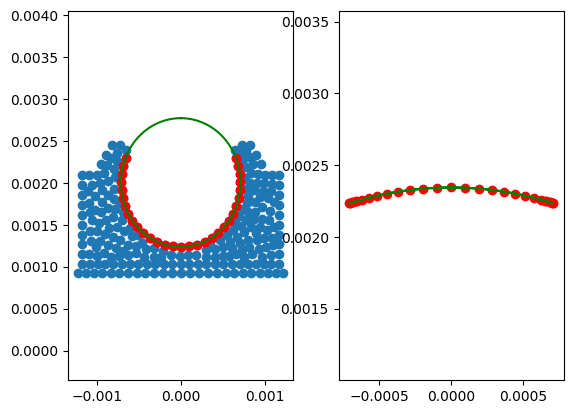

In [55]:

φarray = np.linspace(0, 1, 100) * 2*np.pi
xφarray = np.array([get_xφ(φ) for φ in φarray])

fig,ax = plt.subplots(1,2)
ax[0].plot(wall[:,0], wall[:,2], 'o')
ax[0].plot(wall_edge[:,0], wall_edge[:,2], 'ro')
ax[0].plot(xφarray[:,0], xφarray[:,2], 'g')
ax[0].axis('equal')

ax[1].plot(wall_edge[:,0], wall_edge[:,1], 'ro')
ax[1].plot(xφarray[:,0], xφarray[:,1], 'g')
ax[1].axis('equal')


やりたいこと

1. (python) 境界ノードの特定 →　ファイル出力
   1. 境界に名前付け
   2. 現在の設定（R=2.3mmとか）でちゃんと現在のエッジを再現できるか，ルールの設定・確認
   3. 同じ数式をrustに実装
   4. 対応するエッジ群のインデックスをファイルで出力
2. (rust) 線上のノードを等間隔に並べる
3. (rust) 面上のノードを制約付きスムージングする
4. (rust) 空間のノードを制約なしスムージングする

そもそも・・・

- パラメタを変更したらどう変わる？
  - ロジックだけ握ってればいい？
  - pythonは呼び出す？
  - マッピングだけだったらPythonでもよい．ただ今後インタラクティブ性を考えると・・・？
  - rustだと難しいこと ← エッジ抽出が人力になる ← でもこれは最初の1回だけ

次にやること
- 線のリスト，面のリストを出す．線に関しては並びにも注意する．面はどこかによって制約が異なるため，面の種類ごとに分別して出力する．エッジは含まない．


In [44]:
def np_arctan2(y, x):
    angles = np.arctan2(y, x) - np.pi/2
    return np.where(angles < 0, angles + 2 * np.pi, angles)

In [52]:
wall_edge_angle = np_arctan2((wall_edge[:,2]-Oxyz[2])/dz0, wall_edge[:,0]/dx0)
np.int32(np.rad2deg(wall_edge_angle))


array([187, 179, 172, 156, 148, 141, 133, 126, 119, 111, 104,  97,  89,
        82, 164, 211, 203, 218, 226, 233, 195, 285, 277, 240, 248, 255,
       262, 270, 292,  74,  67], dtype=int32)

(-0.0013447498728055506,
 0.0013447499892208724,
 0.0008377602390709115,
 0.0028670345426833176)

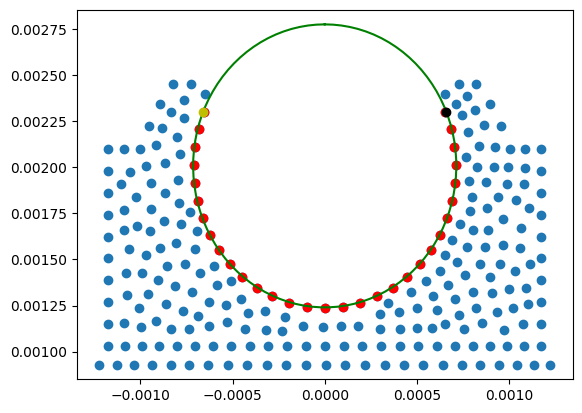

In [53]:
wall_edge_first = wall_edge_angle.min()
wall_edge_end = wall_edge_angle.max()
xφ_first = get_xφ(wall_edge_first)
xφ_middle = get_xφ(wall_edge_end)

plt.plot(wall[:,0], wall[:,2], 'o')
plt.plot(wall_edge[:,0], wall_edge[:,2], 'ro')
plt.plot(xφarray[:,0], xφarray[:,2], 'g')
plt.plot(xφ_first[0], xφ_first[2], 'ko')
plt.plot(xφ_middle[0], xφ_middle[2], 'yo')
plt.axis('equal')


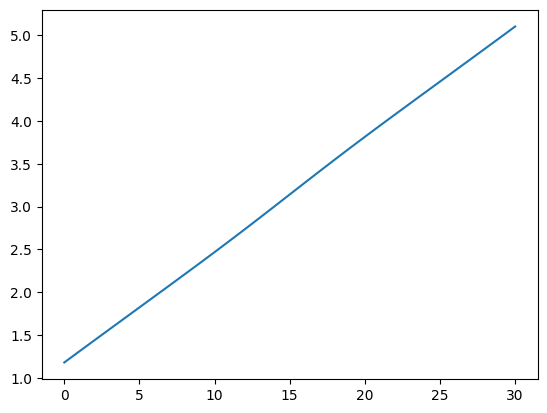

In [54]:
wall_edge_angle.sort()
plt.plot(wall_edge_angle)


In [167]:
point_indices = lambda p: np.where(np.isin(points, p).all(axis=1))[0]
wall_edge_indices = point_indices(wall_edge)

print(wall_edge[:4,0])
print(points[wall_edge_indices,0][:4])
print(wall_edge_indices.shape)
print(wall_edge_indices[:6])


[ 9.77182062e-05 -5.46314949e-09 -9.77289455e-05 -2.84502981e-04]
[ 9.77182062e-05 -5.46314949e-09 -9.77289455e-05 -2.84502981e-04]
(31,)
[38 40 41 52 54 56]


In [168]:
Oxyz_face_indices = point_indices(Oxyz_face)
# Oxyz_face_indices = np.setdiff1d(wall_edge_indices, Oxyz_face_indices)

print(Oxyz_face[:4,0])
print(points[Oxyz_face_indices,0][:4])
print(Oxyz_face_indices.shape)
print(Oxyz_face_indices[18:24])


[-0.00069842 -0.00074698 -0.00030611 -0.00020686]
[-0.00069842 -0.00074698 -0.00030611 -0.00020686]
(165,)
[38 39 40 41 42 43]


In [169]:
# Create new indices by removing wall_edge_indices from Oxyz_face_indices
new_indices = np.setdiff1d(Oxyz_face_indices, wall_edge_indices)
new_indices[18:24]


array([39, 42, 43, 44, 45, 46])

xmlのイメージ．Edgeは並び順に注意．FaceはEdgeを含まない．

```xml
<Edge>
    <InPocket>
        8 39 40 41 42 43
    </InPocket>
    <OutPocket>
        8 39 40 41 42 43
    </OutPocket>}
    <InLine>
        8 39 40 41 42 43
    </InLine>
    <InBottomLine>
        8 39 40 41 42 43
    </InBottomLine>
</Edge>
<Face>
    <Pocket>
        8 39 40 41 42 43
    </Pocket>
</Face>
```